## Importing Modules

In [1]:
import os
import pickle
import numpy as np
from tqdm.notebook import tqdm

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add

In [2]:
BASE_DIR = 'archive'
WORKING_DIR = 'working'

## Extracting Features

In [3]:
# Load vgg16 model
model = VGG16()
# Restructuring the model
model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
# Summarize
print(model.summary())

553467096/553467096 ━━━━━━━━━━━━━━━━━━━━ 151s 0us/step


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, 224, 224, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, 224, 224, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, 112, 112, 128)  │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, 112, 112, 128)  │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, 56, 56, 256)    │       295,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, 56, 56, 256)    │       590,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, 28, 28, 256)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, 28, 28, 512)    │     1,180,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, 28, 28, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, 14, 14, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, 14, 14, 512)    │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_pool (MaxPooling2D)      │ (None, 7, 7, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 25088)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc1 (Dense)                     │ (None, 4096)           │   102,764,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ fc2 (Dense)                     │ (None, 4096)           │    16,781,312 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 134,260,544 (512.16 MB)

 Trainable params: 134,260,544 (512.16 MB)

 Non-trainable params: 0 (0.00 B)

None


In [4]:
# Extracting features from image
features = {}
directory = os.path.join(BASE_DIR, 'Images')

for img_name in tqdm(os.listdir(directory)):
    # Load the image from file
    img_path = directory + '/' + img_name
    image = load_img(img_path, target_size=(224, 224))
    # Convert image pixels to numpy array
    image = img_to_array(image)
    # Reshape data for model
    image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
    # Preprocess image for vgg16
    image = preprocess_input(image)
    # Extract features
    feature = model.predict(image, verbose=0)
    # Get image ID
    image_id = img_name.split('.')[0]
    features[image_id] = feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [5]:
# Store features in pickle
pickle.dump(features, open(os.path.join(WORKING_DIR, 'features.pkl'), 'wb'))

In [6]:
# Load features from pickle
with open(os.path.join(WORKING_DIR, 'features.pkl'), 'rb') as f:
    features = pickle.load(f)

## Loading Captions Data

In [7]:
with open(os.path.join(BASE_DIR, 'captions.txt'), 'r') as f:
    next(f)
    captions_doc = f.read()

In [8]:
# Create mapping of image to captions
mapping = {}
# Process lines
for line in tqdm(captions_doc.split('\n')):
    # Split the line by comma(,)
    tokens = line.split(',')
    if len(line) < 2:
        continue
    image_id, caption = tokens[0], tokens[1:]
    # Remove extension from image ID
    image_id = image_id.split('.')[0]
    # Convert caption list to string
    caption = " ".join(caption)
    # Create list if needed
    if image_id not in mapping:
        mapping[image_id] = []
    # Store the caption
    mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [9]:
len(mapping)

8091

## Preprocessing Text Data

In [10]:
def clean(mapping):
    for key, captions in mapping.items():
        for i in range(len(captions)):
            # Select one caption at a time
            caption = captions[i]
            # Convert to lowercase
            caption = caption.lower()
            # Delete digits, special chars, etc. 
            caption = caption.replace('[^A-Za-z]', '')
            # Delete additional spaces
            caption = caption.replace('\s+', ' ')
            # Add start and end tags to the caption
            caption = 'startseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq'
            captions[i] = caption

<>:12: SyntaxWarning: invalid escape sequence '\s'
<>:12: SyntaxWarning: invalid escape sequence '\s'
C:\Users\salla\AppData\Local\Temp\ipykernel_13444\822461702.py:12: SyntaxWarning: invalid escape sequence '\s'
  caption = caption.replace('\s+', ' ')


In [11]:
# Before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [12]:
# Preprocess the text
clean(mapping)

In [13]:
# After preprocess of text
mapping['1000268201_693b08cb0e']

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq']

In [14]:
all_captions = []
for key in mapping:
    for caption in mapping[key]:
        all_captions.append(caption)

In [15]:
len(all_captions)

40455

In [16]:
all_captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

In [17]:
# Tokenize the text
tokenizer = Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size = len(tokenizer.word_index) + 1

In [18]:
vocab_size

8485

In [19]:
# Get maximum length of the caption available
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

## Train Test Split

In [20]:
image_ids = list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test = image_ids[split:]

In [22]:
# Create data generator to get data in batch (avoids session crash)
def data_generator(data_keys, mapping, features, tokenizer, max_length, vocab_size, batch_size):
    # Loop over images
    X1, X2, y = list(), list(), list()
    n = 0
    while 1:
        for key in data_keys:
            n += 1
            captions = mapping[key]
            # Process each caption
            for caption in captions:
                # Encode the sequence
                seq = tokenizer.texts_to_sequences([caption])[0]
                # Split the sequence into X, y pairs
                for i in range(1, len(seq)):
                    # Split into input and output pairs
                    in_seq, out_seq = seq[:i], seq[i]
                    # Pad input sequence
                    in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
                    # Encode output sequence
                    out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
                    
                    # Store the sequences
                    X1.append(features[key][0])
                    X2.append(in_seq)
                    y.append(out_seq)
            if n == batch_size:
                X1, X2, y = np.array(X1), np.array(X2), np.array(y)
                yield {"image": X1, "text": X2}, y
                X1, X2, y = list(), list(), list()
                n = 0

## Model Creation

In [23]:
# Encoder Model
# Image feature layers
inputs1 = Input(shape=(4096,), name="image")
fe1 = Dropout(0.4)(inputs1)
fe2 = Dense(256, activation='relu')(fe1)
# Sequence feature layers
inputs2 = Input(shape=(max_length,), name="text")
se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
se2 = Dropout(0.4)(se1)
se3 = LSTM(256)(se2)

# Decoder Model
decoder1 = add([fe2, se3])
decoder2 = Dense(256, activation='relu')(decoder1)
outputs = Dense(vocab_size, activation='softmax')(decoder2)

model = Model(inputs=[inputs1, inputs2], outputs=outputs)
model.compile(loss='categorical_crossentropy', optimizer='adam')

# Plot the model
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [24]:
# Train the model
epochs = 20
batch_size = 32
steps = len(train) // batch_size

for i in range(epochs):
    # Create data generator
    generator = data_generator(train, mapping, features, tokenizer, max_length, vocab_size, batch_size)
    # Fit for one epoch
    model.fit(generator, epochs=1, steps_per_epoch=steps, verbose=1)

227/227 ━━━━━━━━━━━━━━━━━━━━ 403s 2s/step - loss: 5.7729
227/227 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - loss: 4.0663
227/227 ━━━━━━━━━━━━━━━━━━━━ 525s 2s/step - loss: 3.5795
227/227 ━━━━━━━━━━━━━━━━━━━━ 494s 2s/step - loss: 3.2985
227/227 ━━━━━━━━━━━━━━━━━━━━ 431s 2s/step - loss: 3.1010
227/227 ━━━━━━━━━━━━━━━━━━━━ 442s 2s/step - loss: 2.9435
227/227 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - loss: 2.8249
227/227 ━━━━━━━━━━━━━━━━━━━━ 1075s 5s/step - loss: 2.7329
227/227 ━━━━━━━━━━━━━━━━━━━━ 422s 2s/step - loss: 2.6502
227/227 ━━━━━━━━━━━━━━━━━━━━ 496s 2s/step - loss: 2.5789
227/227 ━━━━━━━━━━━━━━━━━━━━ 448s 2s/step - loss: 2.5216
227/227 ━━━━━━━━━━━━━━━━━━━━ 441s 2s/step - loss: 2.4645
227/227 ━━━━━━━━━━━━━━━━━━━━ 435s 2s/step - loss: 2.4156
227/227 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - loss: 2.3682
227/227 ━━━━━━━━━━━━━━━━━━━━ 436s 2s/step - loss: 2.3290
227/227 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - loss: 2.2896
227/227 ━━━━━━━━━━━━━━━━━━━━ 446s 2s/step - loss: 2.2537
227/227 ━━━━━━━━━━━━━━━━━━━━ 4

In [26]:
# Save the model
model.save(WORKING_DIR + '/best_model.h5')

## Generate Captions for the Image

In [27]:
def idx_to_word(integer, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == integer:
            return word
    return None

In [28]:
# Generate caption for an image
def predict_caption(model, image, tokenizer, max_length):
    # Add start tag for generation process
    in_text = 'startseq'
    # Iterate over the max length of sequence
    for i in range(max_length):
        # Encode input sequence
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        # Pad the sequence
        sequence = pad_sequences([sequence], max_length)
        # Predict next word
        yhat = model.predict([image, sequence], verbose=0)
        # Get index with high probability
        yhat = np.argmax(yhat)
        # Convert index to word
        word = idx_to_word(yhat, tokenizer)
        # Stop if word not found
        if word is None:
            break
        # Append word as input for generating next word
        in_text += " " + word
        # Stop if we reach end tag
        if word == 'endseq':
            break
      
    return in_text

In [30]:
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to
[nltk_data]    |     C:\Users\salla\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\cmudict.zip.
[nltk_data]    | Downloading package gazetteers to
[nltk_data]    |     C:\Users\salla\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gazetteers.zip.
[nltk_data]    | Downloading package genesis to
[nltk_data]    |     C:\Users\salla\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\genesis.zip.
[nltk_data]    | Downloading package gutenberg to
[nltk_data]    |     C:\Users\salla\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\gutenberg.zip.
[nltk_data]    | Downloading package inaugural to
[nltk_data]    |     C:\Users\salla\AppData\Roaming\nltk_data...
[nltk_data]    |   Unzipping corpora\inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     C:\Users\salla\AppData\Roaming\nl

True

In [39]:
from nltk.translate.bleu_score import corpus_bleu
# Validate with test data
actual, predicted = list(), list()

for key in tqdm(test):
    # Get actual caption
    captions = mapping[key]
    # Predict the caption for image
    y_pred = predict_caption(model, features[key], tokenizer, max_length) 
    # Split into words
    actual_captions = [caption.split() for caption in captions]
    y_pred = y_pred.split()
    # Append to the list
    actual.append(actual_captions)
    predicted.append(y_pred)

  0%|          | 0/810 [00:00<?, ?it/s]

## Visualize the Results

In [47]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
    # Load the image
    image_id = image_name.split('.')[0]
    img_path = os.path.join(BASE_DIR, "Images", image_name)
    image = Image.open(img_path)
    captions = mapping[image_id]
    print('\t\t\t',' Actual', '\t\t\t')
    for caption in captions:
        print(caption)
    # Predict the caption
    y_pred = predict_caption(model, features[image_id], tokenizer, max_length)
    print('\n')
    print('\t\t\t', 'Predicted', '\t\t\t')
    print(y_pred)
    plt.imshow(image)

			  Actual 			
startseq little boy with bib on is watching the camera endseq
startseq small child in gray and orange winks their eye while holding silverware endseq
startseq tan-skinned child looking at the camera endseq
startseq young boy winks as he is eating endseq
startseq the little boy is holding spoon in his hand whilst winking one eye endseq


			 Predicted 			
startseq young boy winks at the camera endseq


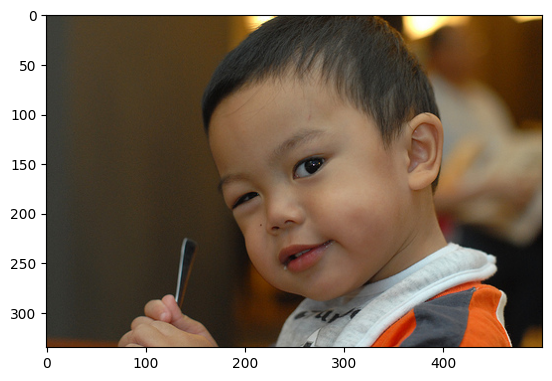

In [56]:
generate_caption("3757598567_739b7da835.jpg")

			  Actual 			
startseq boy at the end of slip and slide endseq
startseq boy is being splashed in the face whilst riding blue ring along yellow water slide endseq
startseq young boy slides down water slide with his eyes closed endseq
startseq young boy slides on slip 'n' slide endseq
startseq young boy splashes down water slide on lawn endseq


			 Predicted 			
startseq boy in green shirt is playing in the sprinkler endseq


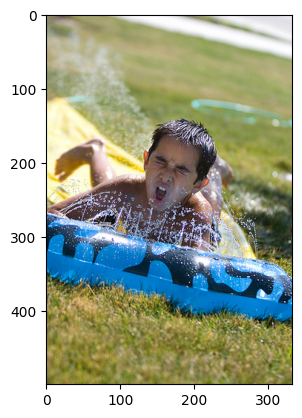

In [54]:
generate_caption("3759230208_1c2a492b12.jpg")

			  Actual 			
startseq kayaker kayaks through the water endseq
startseq person kayaking in the ocean endseq
startseq person kayaks in the middle of the ocean on grey day endseq
startseq person rows boat over large body of water endseq
startseq person in boat with paddle in hand endseq


			 Predicted 			
startseq man is paddling on boat on the shore endseq


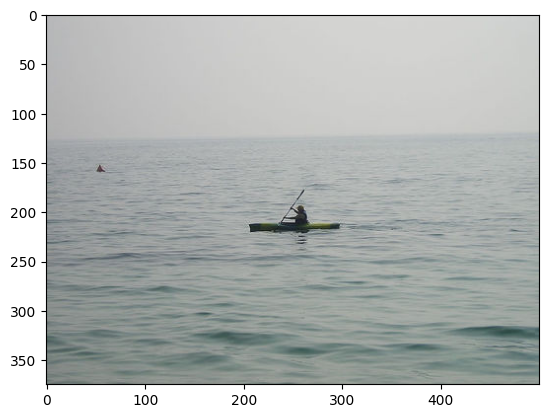

In [55]:
generate_caption("19212715_20476497a3.jpg")

## Test with Real Image

In [51]:
vgg_model = VGG16()
# restructure the model
vgg_model = Model(inputs=vgg_model.inputs, outputs=vgg_model.layers[-2].output)

In [52]:
image_path = 'archive/Images/42637986_135a9786a6.jpg'
# load image
image = load_img(image_path, target_size=(224, 224))
# convert image pixels to numpy array
image = img_to_array(image)
# reshape data for model
image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# preprocess image for vgg
image = preprocess_input(image)
# extract features
feature = vgg_model.predict(image, verbose=0)
# predict from the trained model
predict_caption(model, feature, tokenizer, max_length)

'startseq two people are sitting on dock on dock endseq'